<a href="https://colab.research.google.com/github/Amit-95/Coronavirus_Tweet_sentiment_analysis/blob/main/Coronavirus_Tweet_Sentiment_Analysis_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sentiment Analysis : Predicting sentiment of COVID-19 tweets</u></b>

## <b> Problem Description </b>

### This challenge asks you to build a classification model to predict the sentiment of COVID-19 tweets.The tweets have been pulled from Twitter and manual tagging has been done then.

### The names and usernames have been given codes to avoid any privacy concerns.

### You are given the following information:
1. Location
2. Tweet At
3. Original Tweet
4. Label

## Import Libraries and Data

In [28]:
# Import necessary libraries

import pandas as pd
import numpy as np
from numpy import math
pd.pandas.set_option('display.max_columns',None)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext google.colab.data_table

import re # for regular expressions
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_word = stopwords.words('english') # load stop words
import nltk # for text manipulation
from nltk.stem.porter import *
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tqdm import tqdm
import gensim

from scipy import stats 
from sklearn import metrics 
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.metrics import make_scorer,classification_report,confusion_matrix
from sklearn.metrics import accuracy_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split,cross_val_score,KFold
from sklearn.metrics import f1_score

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***Load Data from the file coronavirus_tweets.csv***

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
# Read the csv file
data=pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Corona_virus_tweet_analysis_caps_proj/Coronavirus Tweets.csv",encoding='ISO-8859-1')

**First Look**

In [31]:
#First 5 values
data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [32]:

# Last 5 values.
data.tail()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
41152,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral
41153,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative
41154,44953,89905,NaN,14-04-2020,You know itÂs getting tough when @KameronWild...,Positive
41155,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral
41156,44955,89907,i love you so much || he/him,14-04-2020,@TartiiCat Well new/used Rift S are going for ...,Negative


In [33]:

# Check for duplicated entries.
print("Duplicate entry in data:",len(data[data.duplicated()])) 

Duplicate entry in data: 0


In [34]:
# Custom Function for Dtype,Unique values and Null values
def datainfo():
    temp_ps = pd.DataFrame(index=data.columns)
    temp_ps['DataType'] = data.dtypes
    temp_ps["Non-null_Values"] = data.count()
    temp_ps['Unique_Values'] = data.nunique()
    temp_ps['NaN_Values'] = data.isnull().sum()
    temp_ps['NaN_Values_Percentage'] = (temp_ps['NaN_Values']/len(data))*100 
    return temp_ps

In [35]:

# Shape of the data.
print("Total Rows and Columns in DataFrame is :",data.shape,"\n") 
# Custom Function
datainfo()

Total Rows and Columns in DataFrame is : (41157, 6) 



,DataType,Non-null_Values,Unique_Values,NaN_Values,NaN_Values_Percentage
UserName,int64,41157,41157,0,0.000000
ScreenName,int64,41157,41157,0,0.000000
Location,object,32567,12220,8590,20.871298
TweetAt,object,41157,30,0,0.000000
OriginalTweet,object,41157,41157,0,0.000000
Sentiment,object,41157,5,0,0.000000


Here are some statistics for the numerical columns:

In [36]:

# statistics info
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
UserName,41157.0,NaN,NaN,NaN,24377.0,11881.146851,3799.0,14088.0,24377.0,34666.0,44955.0
ScreenName,41157.0,NaN,NaN,NaN,69329.0,11881.146851,48751.0,59040.0,69329.0,79618.0,89907.0
Location,32567,12220,London,540,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TweetAt,41157,30,20-03-2020,3448,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OriginalTweet,41157,41157,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sentiment,41157,5,Positive,11422,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
# dataset contain Text data so its better to convert it into string 
data['OriginalTweet']=data['OriginalTweet'].astype(str)
data['Sentiment']=data['Sentiment'].astype(str)

# STEP 1 : Exploratory Data Analysis

Let's explore the data by visualizing the distribution of values in some columns of the dataset, and the relationships between "charges" and other columns.

In [38]:

# Separate dataframe for EDA
data_E=data.copy()


**Missing Values**

In [39]:
# 1 -step make the list of features which has missing values
feature_with_na=[feature for feature in data_E.columns if data_E[feature].isnull().sum()>1]
# 2- step print the feature name and the percentage of missing values
for feature in feature_with_na:
  print(feature, np.round(data_E[feature].isnull().mean(), 4)*100,  " % missing values")

Location 20.87  % missing values


In [40]:
# Data has 5 clases of Sentiments,convert them into 3
def classes_con(x):

  if x == 'Extremely Positive':
    return "Positive"
  if x == 'Positive':
    return "Positive"   
  elif x == "'Extremely Negative":
    return "Negative"  
  elif x == "Negative":  
    return "Negative"  
  else:
    return "Neutral" 

data_E["Sentiment"]=data_E["Sentiment"].apply(lambda x:classes_con(x))    

data_E.Sentiment.value_counts()

Positive    18046
Neutral     13194
Negative     9917
Name: Sentiment, dtype: int64

***Sentiment Analysis***

In [41]:
analysis_1= data_E.groupby("Sentiment").count()['OriginalTweet'].reset_index().sort_values(by='OriginalTweet',ascending=False)
analysis_1

,Sentiment,OriginalTweet
2,Positive,18046
1,Neutral,13194
0,Negative,9917


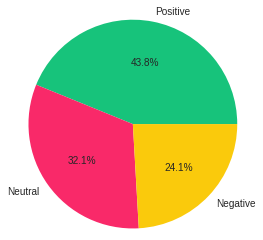

In [42]:
# count plot on Sentiment categorical variable
percent_class = analysis_1['OriginalTweet']
labels= analysis_1.Sentiment
colors = ['#17C37B','#F92969','#FACA0C']
fig=plt.pie(percent_class,labels=labels,colors=colors,autopct="%.1f%%",radius =1.2)

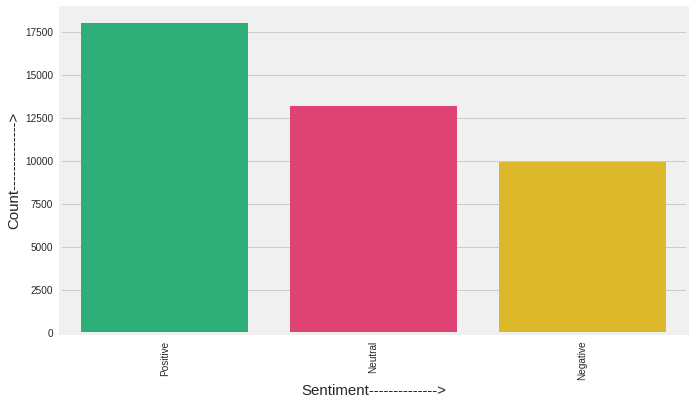

In [43]:

# ploting countplot for "Sentiment" column
plt.figure(figsize=(10,6))
plt.style.use("fivethirtyeight")
sns.countplot('Sentiment',data=data_E,order=data_E.Sentiment.value_counts().index,palette = ['#17C37B','#F92969','#FACA0C'])
plt.xlabel("Sentiment-------------->", fontsize=15)
plt.ylabel("Count-------------->", fontsize=15)
plt.xticks(rotation=90)
plt.show();

Number of characters

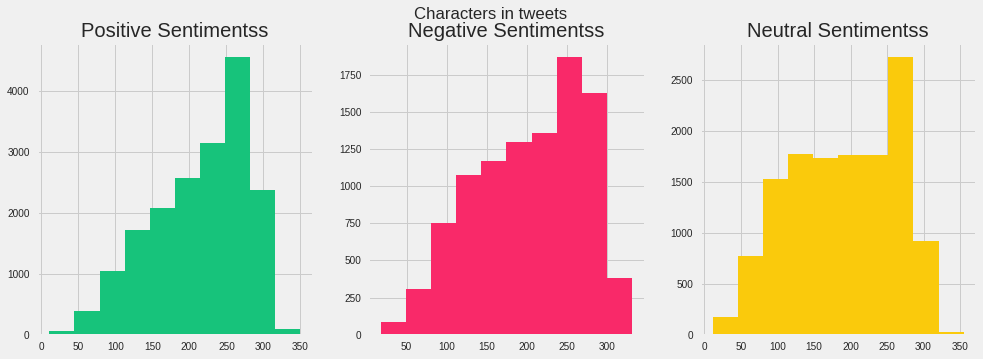

In [44]:
# Histogram
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

# Histogram for Positive Sentiments
tweet_len= data_E[data_E['Sentiment'] == "Positive"]["OriginalTweet"].str.len()
ax1.hist(tweet_len,color='#17C37B')
ax1.set_title('Positive Sentimentss')

# Histogram for Negative Sentiments
tweet_len=data_E[data_E['Sentiment']=="Negative"]['OriginalTweet'].str.len()
ax2.hist(tweet_len,color='#F92969')
ax2.set_title('Negative Sentimentss')

# Histogram for Neutral Sentiments
tweet_len=data_E[data_E['Sentiment']=="Neutral"]['OriginalTweet'].str.len()
ax3.hist(tweet_len,color='#FACA0C')
ax3.set_title('Neutral Sentimentss')

fig.suptitle('Characters in tweets')
plt.show()
     

Number of words in a Tweet

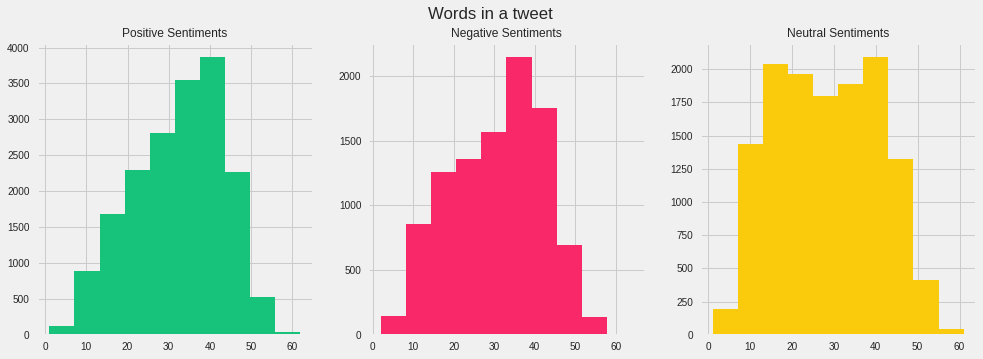

In [45]:
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))
plt.style.use('seaborn')
# Histogram for Positive Sentiments
tweet=data_E[data_E['Sentiment']=="Positive"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax1.hist(tweet,color='#17C37B')
ax1.set_title('Positive Sentiments')

# Histogram for Negative Sentiments
tweet=data_E[data_E['Sentiment']=="Negative"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax2.hist(tweet,color='#F92969')
ax2.set_title('Negative Sentiments')

# Histogram for Neutral Sentiments
tweet=data_E[data_E['Sentiment']=="Neutral"]['OriginalTweet'].str.split().map(lambda x: len(x))
ax3.hist(tweet,color='#FACA0C')
ax3.set_title('Neutral Sentiments')

fig.suptitle('Words in a tweet')
plt.show()
     

**Common Stopwords in a Tweet**

In [46]:

# Dwonloading stopwords from nltk library 
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
# Function to create a corpus 
def create_corpus(target):
    corpus=[] 
    for x in data_E[data_E['Sentiment']==target ]['OriginalTweet'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

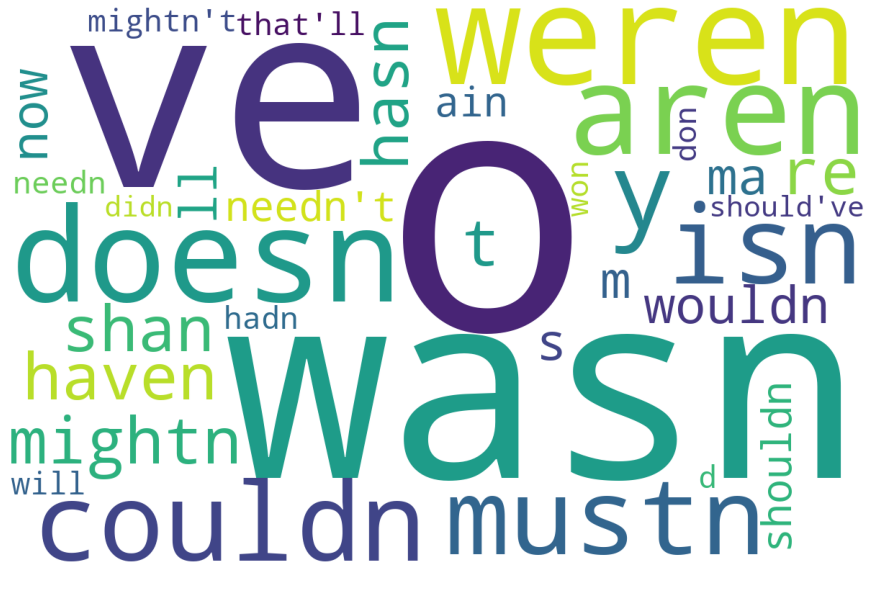

In [48]:
# Cloudword for Stopwords present in dataset

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
comment_words = '' 
stopwords= set(STOPWORDS)

for val in stop:     
    # typecaste each val to string 
    val = str(val) 
    # split the value 
    tokens = val.split()   
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower()  
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 1200, height = 800, 
                background_color ='white',
                stopwords = stopwords, 
                min_font_size = 6).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (12, 8), facecolor = "white") 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
   

<BarContainer object of 10 artists>

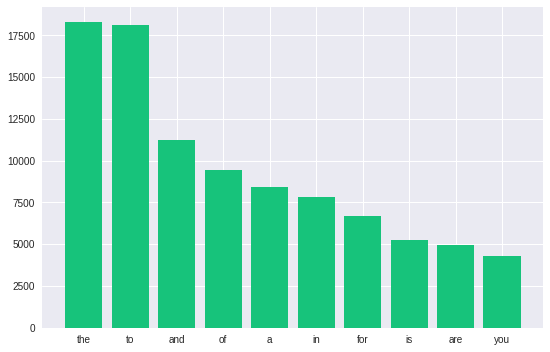

In [49]:

# Stopwords in Positive sentiments
corpus=create_corpus("Positive")
from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1     
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#17C37B')

<BarContainer object of 10 artists>

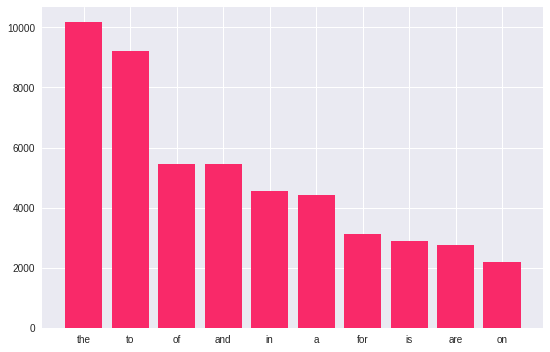

In [50]:
# Stopwords in Negative sentiments
corpus=create_corpus("Negative")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
          
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#F92969')
     

<BarContainer object of 10 artists>

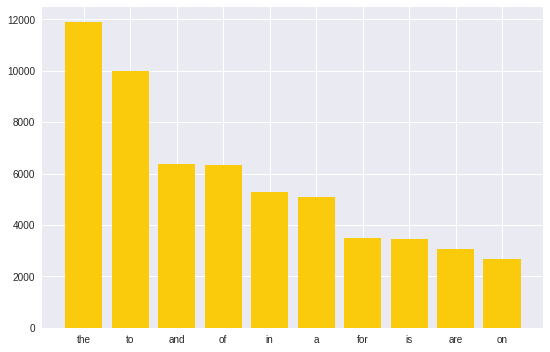

In [51]:
# Stopwords in Neutral sentiments
corpus=create_corpus("Neutral")

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
               
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y, color='#FACA0C')

Punctuations

<BarContainer object of 27 artists>

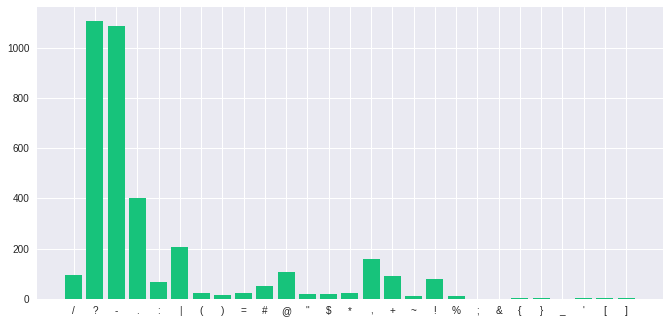

In [52]:
# Punctuations in Positive sentiments
plt.figure(figsize=(10,5))
corpus=create_corpus("Positive")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y,color='#17C37B')

<BarContainer object of 23 artists>

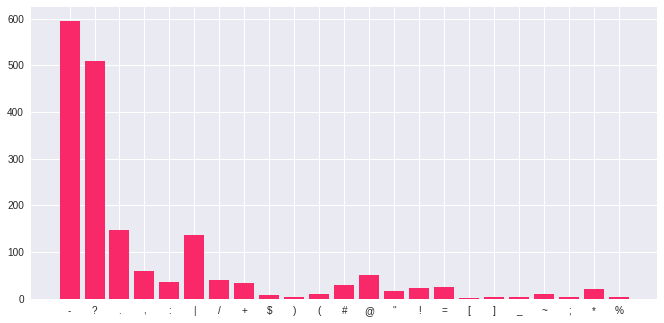

In [53]:

# Punctuations in Negative sentiments
plt.figure(figsize=(10,5))
corpus=create_corpus("Negative")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1
                
x,y=zip(*dic.items())
plt.bar(x,y, color='#F92969')

<BarContainer object of 26 artists>

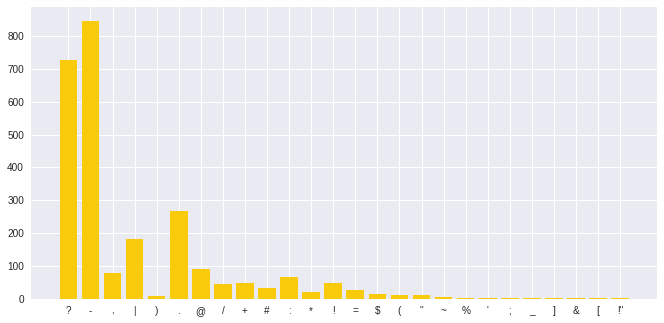

In [54]:
# Punctuations in Neutral sentiments
plt.figure(figsize=(10,5))
corpus=create_corpus("Neutral")

dic=defaultdict(int)
import string
special = string.punctuation
for i in (corpus):
    if i in special:
        dic[i]+=1

        
x,y=zip(*dic.items())
plt.bar(x,y,color='#FACA0C')
     